# Plot the outcome of potential DCO systems

I define "potential DCO" as systems that form a DCO at any metallicity in my discrete grid of metallicities

In [1]:
import numpy as np
from astropy.table import Table
import os 
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import colorsys

from tkinter import font
from matplotlib.gridspec import GridSpec
from pyrsistent import b


home_dir = os.path.expanduser("~") 
datar_root = home_dir + "/ceph/CompasOutput/v02.46.01/"#v02.35.02/"
sim_name =  'OldWinds_RemFryer2012'#  

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))



# Data manipulation

Happens in [ DataManipulation notebook](./DataManipulation.ipynb)

In [2]:
####################################
# Take the base potential DCO progenitor table
prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'

if os.path.isfile(datar_root+ f'/{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())
else:
    print('error, table doesnt exist, you should make it using "DataManipulation.ipynb" first')

potential_DCO_progenitors.reset_index(drop=True, inplace=True)
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119952 entries, 0 to 119951
Data columns (total 95 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SEED                                  119952 non-null  uint64 
 1   Metallicity@ZAMS(1)                   119952 non-null  float64
 2   Stellar_Type(1)                       119952 non-null  int32  
 3   Stellar_Type(2)                       119952 non-null  int32  
 4   CE_Event_Counter                      119952 non-null  uint32 
 5   Mass@ZAMS(1)                          119952 non-null  float64
 6   Mass@ZAMS(2)                          119952 non-null  float64
 7   SemiMajorAxis@ZAMS                    119952 non-null  float64
 8   Merger                                119952 non-null  uint8  
 9   Merger_At_Birth                       119952 non-null  uint8  
 10  Unbound                               119952 non-null  uint8  
 11  

## Split your potential DCO table between potential BBH, BHNS and NSNS

In [3]:
with h5.File(datar_root+f'{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
    DCO = All_data['BSE_Double_Compact_Objects']
    st1 = DCO['Stellar_Type(1)'][()]
    st2 = DCO['Stellar_Type(2)'][()]
    dco_merger = DCO['Merges_Hubble_Time'][()]  
    DCO_seed = DCO['SEED'][()]
    # Now I want to add a bool that tells me if this system is ever a BBH, BHNS or BNS progenitor
    BBH_bool = np.logical_and(st1 == 14,st2 == 14)
    BHNS_bool = np.logical_or(np.logical_and(st1 == 13,st2 == 14),
                            np.logical_and(st1 == 14,st2 == 13) )
    NSNS_bool = np.logical_and(st1 == 13,st2 == 13)
    merger_bool = dco_merger == 1

    # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
    potential_BBH_progenitors  = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BBH_bool*merger_bool]) )]
    potential_BHNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BHNS_bool*merger_bool]) )]
    potential_NSNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[NSNS_bool*merger_bool]) )]



# Now plot the endpoint of all potential DCO systems at different metallicities



In [4]:

def get_endpoint_numbers(table = potential_DCO_progenitors):

    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog  = grouped_byZ.size()

    N_unbound       = grouped_byZ['Unbound'].apply(lambda x: (x==1).sum())
    N_mergers       = grouped_byZ['Merger'].apply(lambda x: (x==1).sum())

    # Make sure all the things below are not unbound or mergers
    not_unbound_nor_merger = np.logical_and(table['Unbound'] == 0, table['Merger'] == 0)
    DCO_merger      = (table['Merges_Hubble_Time'] == 1)

    N_BBH           = grouped_byZ.apply(lambda x: (not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 
    N_mergingBBH    = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger &  np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 14)).sum() ) 

    N_BHNS          = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())
    N_mergingBHNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_or(np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 14),
                                                        np.logical_and(x['Stellar_Type(1)'] == 14, x['Stellar_Type(2)'] == 13))).sum())

    N_NSNS          = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )
    N_mergingNSNS   = grouped_byZ.apply(lambda x: (DCO_merger & not_unbound_nor_merger & np.logical_and(x['Stellar_Type(1)'] == 13, x['Stellar_Type(2)'] == 13)).sum() )

    N_WD            = grouped_byZ.apply(lambda x: (not_unbound_nor_merger & np.logical_or(x['Stellar_Type(1)'].isin([10, 11, 12]), x['Stellar_Type(2)'].isin([10, 11, 12]))).sum())
    N_massless_rem  =  grouped_byZ.apply(lambda x: (not_unbound_nor_merger &np.logical_or(x['Stellar_Type(1)'] == 15, x['Stellar_Type(2)'] == 15)).sum() ) 


    # IDK whats going on here?
    not_unbound         = table['Unbound'] == 0
    not_merger          = table['Merger'] == 0
    not_BBH             = ~np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14)
    not_NSBH            = ~np.logical_or(np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 14),
                                np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 13))
    not_NSNS            = ~np.logical_and(table['Stellar_Type(1)'] == 13, table['Stellar_Type(2)'] == 13)
    not_massless_rem    = ~(np.logical_or(table['Stellar_Type(1)'] == 15, table['Stellar_Type(2)'] == 15))
    not_WD              = ~(np.logical_or(table['Stellar_Type(1)'].isin([10, 11, 12]), table['Stellar_Type(2)'].isin([10, 11, 12])))

    other_bool = not_unbound* not_merger * not_BBH * not_NSBH * not_NSNS * not_massless_rem * not_WD
    # Check if there are thing that are both listed as BBH and unbound
    BBH_and_unbound = (np.logical_and(table['Stellar_Type(1)'] == 14, table['Stellar_Type(2)'] == 14) * (table['Unbound'] == 1)  )
    print('BBH and unbound', BBH_and_unbound.sum())

    return  N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool


# N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = get_endpoint_numbers(table = potential_DCO_progenitors)


In [5]:
# Preload the data to speed up the plotting 
# List of panda tables of pot DCO progenitors
titles = ["All", "BBH", "BHNS", "NSNS"]
# List of tables of pot DCO progenitors
dfs = [potential_DCO_progenitors, potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# Initialize an empty dictionary to store the results
results = {}

# Loop over the dataframes and titles
for df, title in zip(dfs, titles):
    # Get the results from get_endpoint_numbers
    results[title] = get_endpoint_numbers(table = df)



BBH and unbound 27295
BBH and unbound 6264
BBH and unbound 676
BBH and unbound 40


metallicities [0.0001     0.00017321 0.0003     0.00054772 0.001      0.002
 0.004      0.00632456 0.01       0.01414214 0.02       0.03      ]


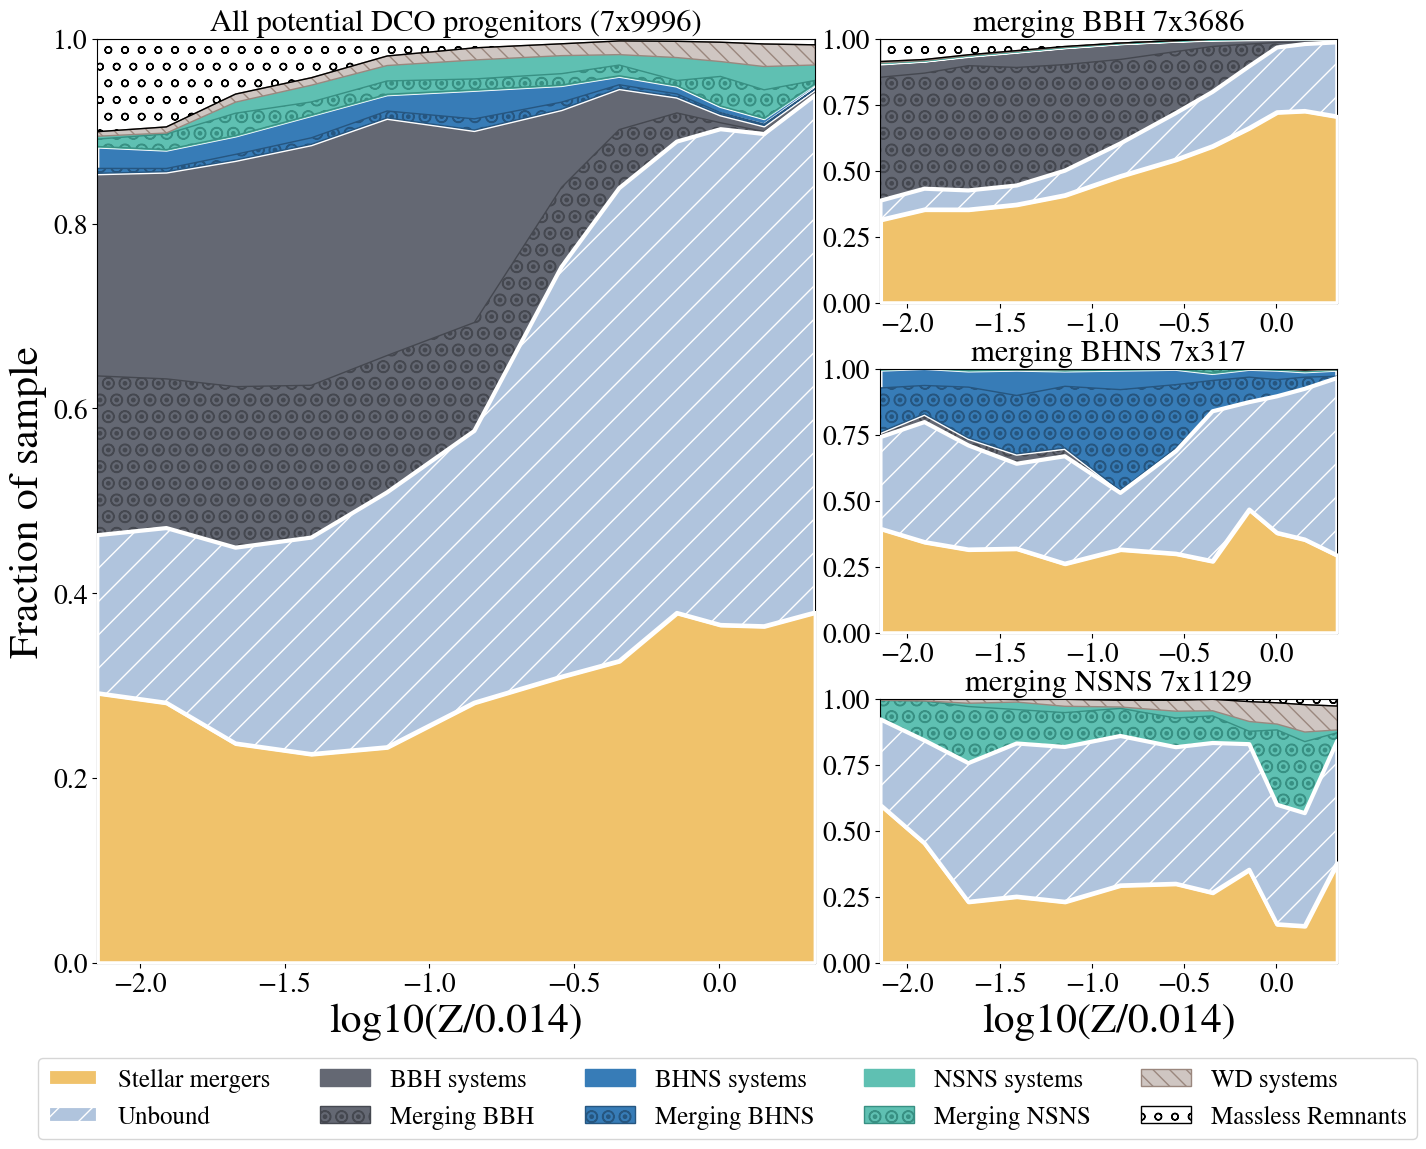

In [7]:
metallicities = np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)

###########################################
# Create a figure
fig = plt.figure(figsize=(16, 12))

# Create a GridSpec with 3 rows and 2 columns
gs = GridSpec(3, 10, figure=fig)#, width_ratios=[60, 40])
ax1 = fig.add_subplot(gs[:, 0:6])    # Create a big subplot on the left (for all DCOs)
axes = [ax1, fig.add_subplot(gs[0, 6:10]), fig.add_subplot(gs[1, 6:10]), fig.add_subplot(gs[2, 6:10])]  #  3 small subplots on the right


# Colors
color_dict = {'BBH': '#646873', 
              'BHNS': '#377CB7',#'#4D7DAF', #'#e8485a', 
              'NSNS': '#5FC0B2',#'#8ECCF2', #'#8CBFDA',#'#778FD2',#91c74c',
              'WDWD': '#cfc6c2',
              'masslessRemnants': '#000000',
              'StellarMergers': '#F0C26B', #'#DDBD76'
              'UnboundSystems': '#b0c4dd'} #'#F4C6B9'


DCO_flavors = ["All", "BBH", "BHNS", "NSNS"]
# Loop over the axes and DCO flavors
for ax, flavor in zip(axes, DCO_flavors):
    N_tot_DCO_prog, N_unbound, N_mergers, N_BBH, N_mergingBBH, N_BHNS, N_mergingBHNS, N_NSNS, N_mergingNSNS, N_WD, N_massless_rem, other_bool = results[flavor] # get_endpoint_numbers(table = df)

    # Normalize or abs numbers?
    norm = N_tot_DCO_prog

    bottom = np.zeros(len(Z_Zsun))

    # stellar mergers
    ax.fill_between(Z_Zsun, bottom/norm, N_mergers/norm, color=color_dict['StellarMergers'], 
                    edgecolor = 'white', lw = 3, label='Stellar mergers', alpha = 1, zorder = 10)
    bottom += N_mergers

    # Unbound systemd
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_unbound)/norm, color=color_dict['UnboundSystems'],
                     edgecolor = 'white', lw = 3,  hatch='/', label='Unbound', alpha = 1, zorder = 10)
    bottom += N_unbound

    # BBH systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BBH)/norm, color=color_dict['BBH'], label='BBH systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBBH)/norm, color=color_dict['BBH'], 
                    edgecolor = darken_color(color_dict['BBH'], factor=0.7), hatch='O.', label='Merging BBH', alpha = 1)
    bottom += N_BBH

    # BHNS systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BHNS)/norm, color=color_dict['BHNS'], label='BHNS systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_BHNS)/norm, color="none", 
                    edgecolor = 'white', lw = 3, label=None, alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingBHNS)/norm, color=color_dict['BHNS'], 
                    edgecolor = darken_color(color_dict['BHNS'], factor=0.7), hatch='O.', label='Merging BHNS', alpha = 1)
    bottom += N_BHNS

    # NSNS systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_NSNS)/norm, color=color_dict['NSNS'], label='NSNS systems', alpha = 1)
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_mergingNSNS)/norm, color=color_dict['NSNS'], 
                    edgecolor = darken_color(color_dict['NSNS'], factor=0.7), hatch='O.', label='Merging NSNS', alpha = 1)
    bottom += N_NSNS

    # WD systems
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_WD)/norm, color=color_dict['WDWD'],
                     edgecolor=darken_color(color_dict['WDWD'], factor=0.7), hatch = '\\\\', label='WD systems', alpha = 1)   
    bottom += N_WD

    # Massless remnants
    ax.fill_between(Z_Zsun, bottom/norm, (bottom + N_massless_rem)/norm, color='none',edgecolor=color_dict['masslessRemnants'], hatch = 'o', label='Massless Remnants', alpha = 1)
    bottom += N_massless_rem

    # Other
    # print(N_other)
    # ax.fill_between(Z_Zsun, bottom, (bottom + N_other)/norm, color='r', label='Other', alpha = 1)

    if flavor == 'All':
        ax.set_title(f'All potential DCO progenitors (7x{N_tot_DCO_prog[0.0001]})', fontsize = 22)
    else:
        ax.set_title(f'merging {flavor} 7x{N_tot_DCO_prog[0.0001]}', fontsize = 22)
        
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_ylim(0,1)

#########################
# plotvalues
fig.subplots_adjust(hspace=0.25, wspace=1)

axes[0].set_xlabel('log10(Z/0.014)', fontsize = 30)
axes[3].set_xlabel('log10(Z/0.014)', fontsize = 30)
axes[0].set_ylabel("Fraction of sample", fontsize =30)

axes[0].legend(bbox_to_anchor=(-0.1, -0.09), loc='upper left', fontsize = 18, ncols = 5)
# axes[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize = 20)

plt.savefig(f'../plots/End_Of_Evol_per_Z_{sim_name}.pdf', bbox_inches='tight')
plt.show()
